## Import Toolkit

In [1]:
#import os libs
import os
import shutil
import itertools
import pathlib
from PIL import Image
#import Data handling
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.metrics import confusion_matrix , classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
#import Deep learning tools
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Dense , BatchNormalization , Dropout,Flatten , Activation
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers
from keras.callbacks import ModelCheckpoint

#Warnings
import warnings
warnings.filterwarnings('ignore')

## Upload Data

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# import os
# os.chdir('/content/drive/MyDrive/5_AIADVANCE')

In [4]:
# root_dir = '/content/drive/MyDrive/5_AIADVANCE/GK_AI_Advance/'
root_dir = 'Data'

# Đường dẫn tới thư mục con 'train', 'val' và 'test'
train_dir = os.path.join(root_dir, 'train')
val_dir = os.path.join(root_dir, 'val')
test_dir = os.path.join(root_dir, 'test')

In [5]:
img_size = (224 , 224)
batch_size = 8
img_shape = (img_size[0] , img_size[1] , 3)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_directory(train_dir , target_size = img_size , class_mode = 'categorical' ,
                                       color_mode = 'rgb' , shuffle = True , batch_size = batch_size)

valid_gen = ts_gen.flow_from_directory(val_dir , target_size = img_size , class_mode = 'categorical' ,
                                       color_mode = 'rgb' , shuffle = True , batch_size = batch_size)

test_gen = ts_gen.flow_from_directory(test_dir , target_size = img_size , class_mode = 'categorical' ,
                                       color_mode = 'rgb' , shuffle = False , batch_size = batch_size)

Found 349 images belonging to 2 classes.
Found 99 images belonging to 2 classes.
Found 52 images belonging to 2 classes.


## Show Sample From Train Data

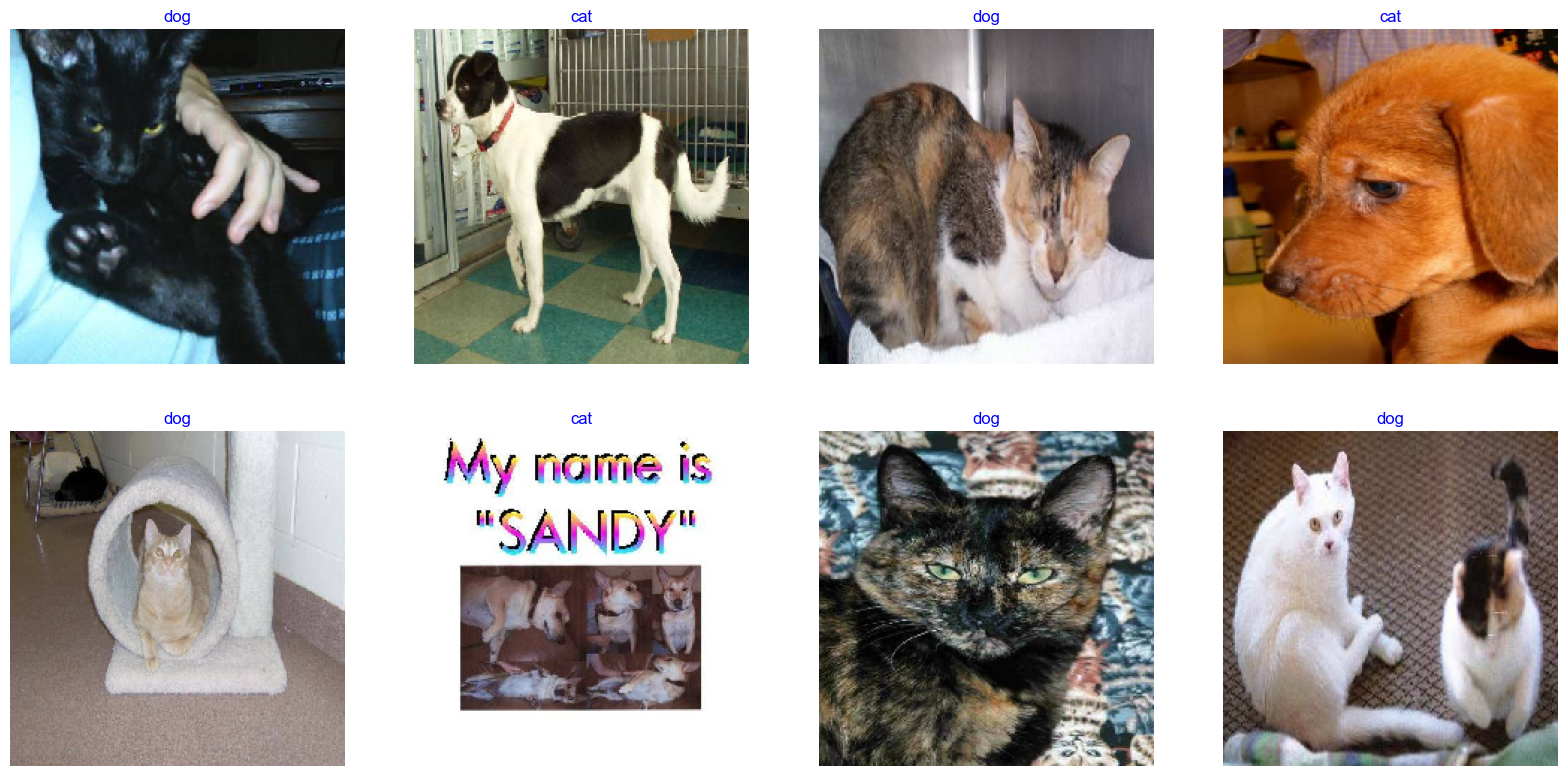

In [6]:
g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images, labels = next(train_gen)
num_samples = len(images)

plt.figure(figsize=(20, 20))

for i in range(min(16, num_samples)):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255
    plt.imshow(image)
    # class_index = int(labels[i]) # binary 
    class_index = int(labels[i][0]) # categorical
    class_name = classes[class_index]
    plt.title(class_name, color='blue', fontsize=12)
    plt.axis('off')
plt.show()

## Model

In [7]:
import tensorflow as tf
from tensorflow.keras import layers

class Block(tf.keras.Model):
    def __init__(self, in_channels, out_channels, expansion, strides):
        super(Block, self).__init__()
        self.strides = strides
        channels = expansion * in_channels

        self.conv1 = layers.Conv2D(channels, kernel_size=1, use_bias=False)
        self.bn1 = layers.BatchNormalization()
        self.conv2 = layers.Conv2D(channels, kernel_size=3, strides=strides, padding='same',
                                   groups=channels, use_bias=False)
        self.bn2 = layers.BatchNormalization()
        self.conv3 = layers.Conv2D(out_channels, kernel_size=1, use_bias=False)
        self.bn3 = layers.BatchNormalization()

        if strides == 1 and in_channels != out_channels:
            self.shortcut = tf.keras.Sequential([
                layers.Conv2D(out_channels, kernel_size=1, use_bias=False),
                layers.BatchNormalization()
            ])
        else:
            self.shortcut = lambda x: x

    def call(self, x):
        out = tf.keras.activations.relu(self.bn1(self.conv1(x)))
        out = tf.keras.activations.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out = layers.add([self.shortcut(x), out]) if self.strides==1 else out
        return out

class MobileNetV2(tf.keras.Model):
    config = [(1, 16, 1, 1),
              (6, 24, 2, 1),
              (6, 32, 3, 2),
              (6, 64, 4, 2),
              (6, 96, 3, 1),
              (6, 160, 3, 2),
              (6, 320, 1, 1)]

    def __init__(self, num_classes):
        super(MobileNetV2, self).__init__()
        self.conv1 = layers.Conv2D(32, kernel_size=3, padding='same', use_bias=False)
        self.bn1 = layers.BatchNormalization()
        self.layer = self._make_layers(in_channels=32)
        self.conv2 = layers.Conv2D(1280, kernel_size=1, use_bias=False)
        self.bn2 = layers.BatchNormalization()
        self.avg_pool2d = layers.AveragePooling2D(pool_size=4)
        self.flatten = layers.Flatten()
        self.fc = layers.Dense(num_classes, activation='softmax')

    def call(self, x):
        out = tf.keras.activations.relu(self.bn1(self.conv1(x)))
        out = self.layer(out)
        out = tf.keras.activations.relu(self.bn2(self.conv2(out)))
        out = self.avg_pool2d(out)
        out = self.flatten(out)
        out = self.fc(out)
        return out

    def _make_layers(self, in_channels):
        layer = []
        for expansion, out_channels, num_blocks, strides in self.config:
            stride = [strides] + [1]*(num_blocks-1)
            for s in stride:
                layer += [Block(in_channels, out_channels, expansion, s)]
                in_channels = out_channels
        return tf.keras.Sequential(layer)

In [8]:
# Create model
# model = build_efficientnet_b7(num_classes = 2)
model = MobileNetV2(num_classes = 2)
# model = DenseNet(model_type = 'densenet121', num_classes = 2)
# model.summary()

In [9]:
# Tạo đối tượng optimizer  # SGD
optimizer = tf.keras.optimizers.Adam()

# Thiết lập ModelCheckpoint
save_best_only = True
# checkpoint = ModelCheckpoint('models/model-DenseNet121-{epoch:03d}.keras',
#                              monitor='val_loss',
#                              verbose=1,
#                              save_best_only=save_best_only,
#                              mode='auto')

# Xây dựng quy trình huấn luyện
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Huấn luyện mô hình với dữ liệu đã chuẩn bị
H = model.fit(
    train_gen,
    steps_per_epoch = train_gen.samples // train_gen.batch_size,
    validation_data = valid_gen,
    validation_steps = valid_gen.samples // valid_gen.batch_size,
    epochs = 10,
    # callbacks=[checkpoint]
)

Epoch 1/10

 3/43 ━━━━━━━━━━━━━━━━━━━━ 20:36 31s/step - accuracy: 0.4514 - loss: 0.7016

## Model Performance

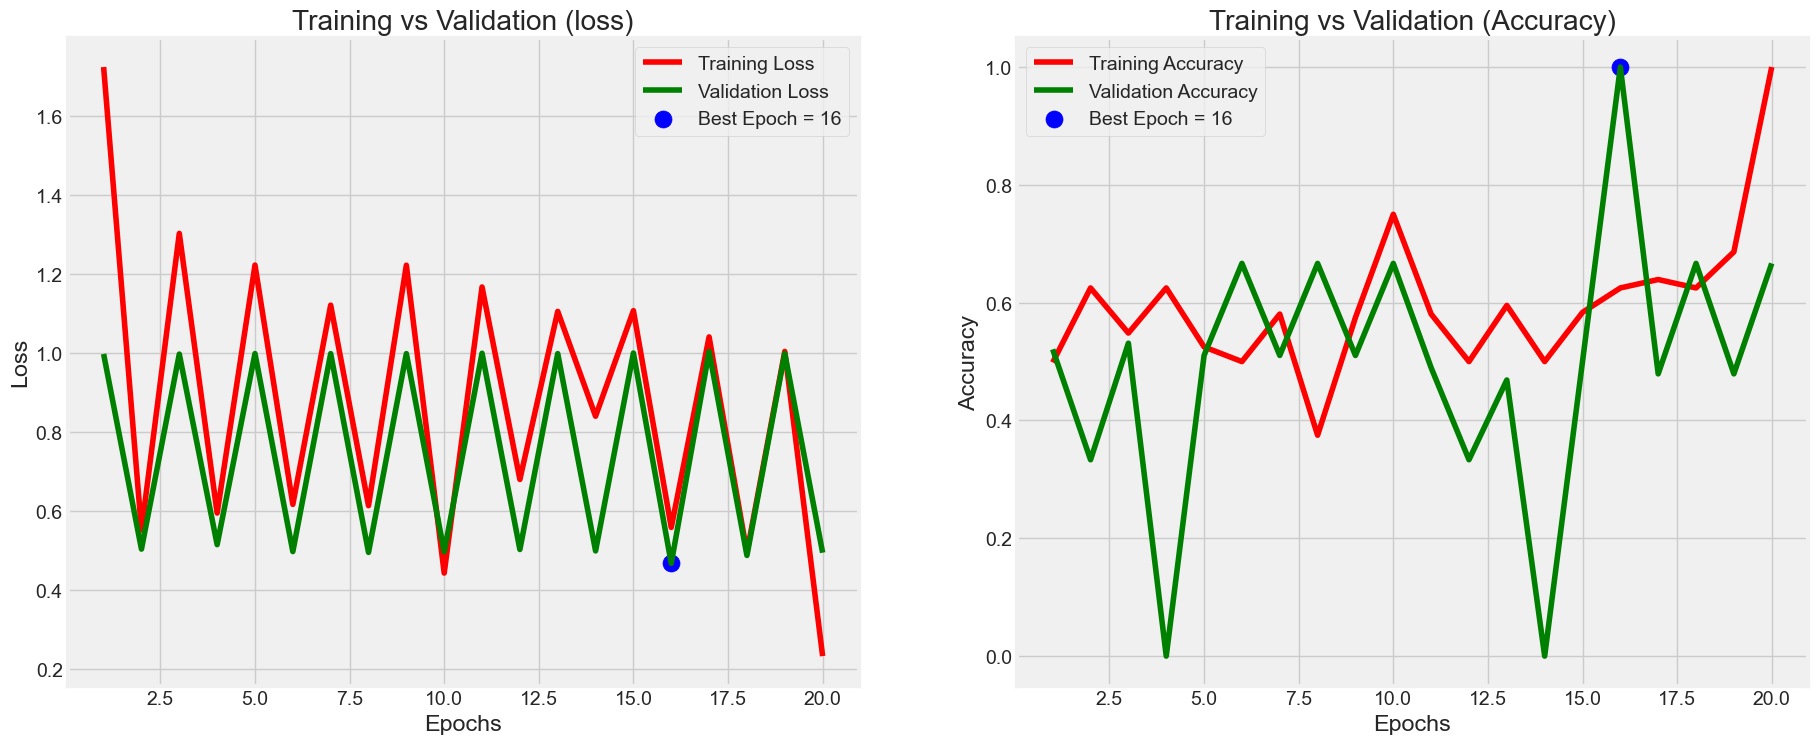

In [ ]:
train_acc = H.history['accuracy']
train_loss = H.history['loss']

val_acc = H.history['val_accuracy']
val_loss = H.history['val_loss']

index_loss = np.argmin(val_loss)
index_acc = np.argmax(val_acc)

val_lowest = val_loss[index_loss]
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best Epoch = {str(index_loss + 1)}'
acc_label = f'Best Epoch = {str(index_acc + 1)}'

plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r', label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss +1 , val_lowest , s = 150 , c = 'blue' , label = loss_label)
plt.title('Training vs Validation (loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r', label= 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s= 150 , c = 'blue' , label= acc_label)
plt.title('Training vs Validation (Accuracy)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

## Model Evaluation

In [ ]:
train_score = model.evaluate(train_gen , steps= 32 , verbose = 1)
val_score = model.evaluate(valid_gen , steps = 32 , verbose = 1)
test_score = model.evaluate(test_gen , steps = 32 , verbose = 1)

print(f'Train loss = {train_score[0] }')
print(f'Train Accuracy = {train_score[1]}')
print(f'Validation loss = {val_score[0]}')
print(f'Validation Accuracy = {val_score[1]}')
print(f'Test loss = {test_score[0]}')
print(f'Test Accuracy = {test_score[1]}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.5324 - loss: 0.9971
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.4470 - loss: 0.9583
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4193 - loss: 0.9039 
Train loss = 0.999745786190033
Train Accuracy = 0.48046875
Validation loss = 0.9269604682922363
Validation Accuracy = 0.4848484992980957
Test loss = 0.8731155395507812
Test Accuracy = 0.48076921701431274


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Dự đoán
preds = model.predict(test_gen)
preds = np.argmax(preds, axis=1)

# Lấy nhãn thật
true_labels = test_gen.classes

# Tính các chỉ số
report = classification_report(true_labels, preds, output_dict=True)

# In chỉ số f1, precision, recall
print("F1:", report['weighted avg']['f1-score'])
print("Precision:", report['weighted avg']['precision'])
print("Recall:", report['weighted avg']['recall'])

6/7 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/stepWARNING:tensorflow:5 out of the last 15 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001A3F26A4160> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 197ms/step
F1: 0.31218781218781216
Precision: 0.2311390532544379
Recall: 0.4807692307692308


In [ ]:
print(classification_report(true_labels, preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.48      1.00      0.65        25

    accuracy                           0.48        52
   macro avg       0.24      0.50      0.32        52
weighted avg       0.23      0.48      0.31        52



## Model Prediction

## Confusion Matrix and Classification Report

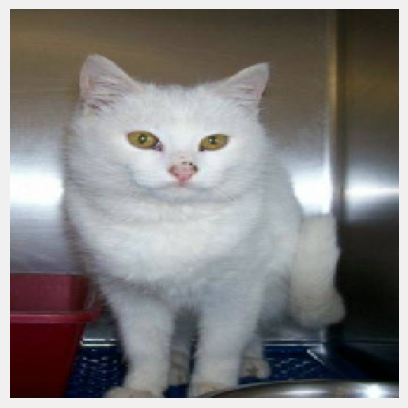

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 839ms/step
Dự đoán: 1


In [ ]:
# Lấy 1 batch dữ liệu từ generator
batch = next(test_gen)
# In hình ảnh đầu tiên
img = batch[0][0]
img = img.astype(float)/255
plt.imshow(img)
plt.axis('off')
plt.show()

# Chuyển đổi thành 4D tensor
img = np.expand_dims(img, axis=0)

# Dự đoán
pred = model.predict(img)
print('Dự đoán:', np.argmax(pred))

In [ ]:
# Tính confusion matrix
conf_mat = confusion_matrix(true_labels, preds)

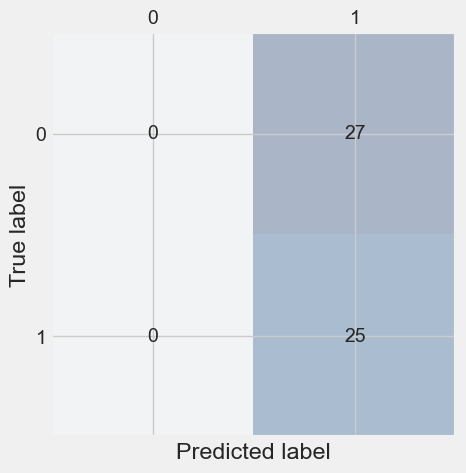

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
ax.matshow(conf_mat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        ax.text(x=j, y=i,s=conf_mat[i,j], va='center', ha='center')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()